In [44]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
from autograd import grad, jacobian
import pennylane as qml

from pennylane import numpy as pnp

# ==============================
# User defined 
# ==============================

In [45]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=3)

# Define Hamiltonian for quantum computations
# H = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

# H = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2)])
# H_1 = qml.Hamiltonian(coeffs=[-0.5, -0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)])

H = qml.Hamiltonian(
    coeffs=[-0.5, -0.5], 
    observables=[
        qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2), 
        qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2)
    ]
)

H_1 = qml.Hamiltonian(
    coeffs=[-0.5, -0.5, -0.5], 
    observables=[qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)]
)

In [46]:
# Global Parameters
Tau_global = 0
Gamma_ps_global = 0
Paras_global = pnp.zeros(6)
Phi_global = pnp.array([0], requires_grad = True)

def Dephase_factor(tau):
    """
    Calculates the dephasing factor as a function of the time parameter tau.

    Args:
        tau (float): A time parameter influencing the dephasing.

    Returns:
        float: The calculated dephasing factor.
    """
    return 1 - pnp.exp(-2 * tau)

In [47]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z1 = Paras_global[1]
    phi_z2 = Paras_global[2]
    phi_z3 = Paras_global[3]
    tau_1 = Paras_global[4]
    tau_2 = Paras_global[5]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    qml.RY(np.pi/2, wires=2)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    qml.PhaseDamping(gamma_dephase, wires = 2)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    
    qml.RX(theta_x, wires = 2)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   
    qml.RY(-np.pi/2, wires = 2)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 
    
    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    qml.RY(np.pi/2, wires = 2) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 

    qml.RZ(phi_z1, wires=0)
    qml.RZ(phi_z2, wires=1)
    qml.RZ(phi_z3, wires=2)
    
    qml.RX(np.pi/(2), wires=0)
    qml.RX(np.pi/(2), wires=1)
    qml.RX(np.pi/(2), wires=2)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1, 2])

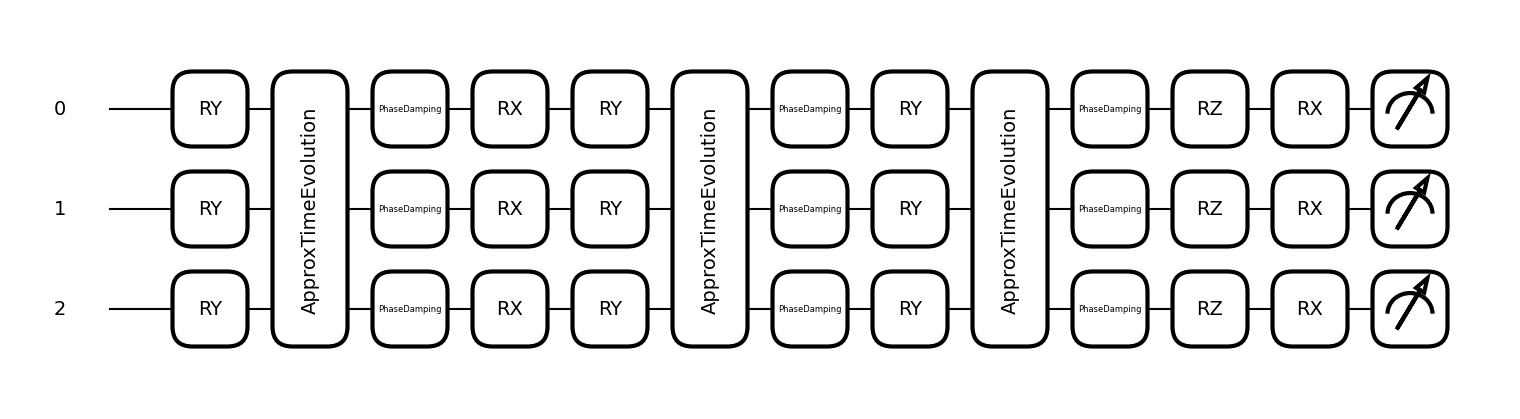

In [48]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [49]:
@qml.qnode(dev)
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = pnp.tensor([
        [pnp.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=pnp.complex128)
    
    Numerator = pnp.kron(K, pnp.kron(K, K)) @ get_density_matrix @ pnp.kron(K, pnp.kron(K, K)).conj().T
    Denominator = pnp.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1, 2])
    
    return qml.density_matrix(wires = [0, 1, 2])  

In [50]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Sets global parameters for dephasing time and gamma post-selection.

    Args:
        desired_tau_dephase (float): The desired dephasing time.
        desired_gamma_post_selection (float): The gamma value for post-selection.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = desired_tau_dephase
    Gamma_ps_global = desired_gamma_post_selection

In [51]:
def cost_function(paras):
    """
    Defines the cost function for optimization, which is the negative of the 
    Classical Fisher Information (CFI).

    Args:
        paras (array): Parameters to optimize.

    Returns:
        float: The negative value of the CFI for the given parameters.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [52]:
class INDEX_3(Enum):
    THETA_X = 0
    
    PHI_Z1 = 1
    PHI_Z2 = 2
    PHI_Z3 = 3
    
    TAU_1 = 4
    TAU_2 = 5
    
def get_constraints(phi_current):
    N =2*np.pi * int(phi_current / (2*np.pi))
    default_0 = [
                (-1e-3, 1e-3),              # THETA_X
                (-float('inf'), float('inf')),       # PHI_Z1
                (-float('inf'), float('inf')),  # PHI_Z2
                (-float('inf'), float('inf')),       # PHI_Z3
                (8.9271456e-01, 8.9271456e-01),   # tau_1
                (np.pi/2, np.pi/2)          # tau_2
            ]
    # temp_0 = default_0
    
    # if 0.51 + N <= phi_current <= 0.81 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (2.07669747, 2.38469112) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (2.09160427, 2.37050667)
    #     return temp_0
        
    # elif 1.21 + N <= phi_current <= 1.81 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (2.77673923, 3.38486445) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (-3.49168366, -2.91311528)
    #     return temp_0
    
    # elif 2.41 + N <= phi_current <= 3.01 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (3.97677551, 4.58495462) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (-2.29178612, -1.71334716)
    #     return temp_0
    
    # elif 3.01 + N <= phi_current <= 3.61 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (-np.pi, 4.68483876)
    #     temp_0[INDEX_3.PHI_Z2.value] = (-1.71334716, -1.11319924)
    #     return temp_0

    # else: 
    return default_0


In [53]:
# ===================
tau_set = np.array([0.005])
gamma_ps_set = 0.8
set_circuit(tau_set, gamma_ps_set)
initial_parameters = np.zeros(6)
initial_parameters[:6] = np.pi/2

initial_parameters[0] = 0
initial_parameters[2] = 0
# ===================
# (-1e-3, 1e-3),              # theta_x
#                 (-1*np.pi/2, 4.67670237),   # phi_z1
#                 (-3.69196329, 6.76972987),  # phi_z2
#                 (-1*np.pi/2, 4.67670237),   # phi_z3
#                 (1.38608592, 1.38608592),   # tau_1
#                 (np.pi/2, np.pi/2)          # tau_2

sweep_range = np.array([1e-2, np.pi*2, 1e-1])
Phi = np.arange(sweep_range[0], sweep_range[1], sweep_range[2])
Data = np.zeros((len(Phi), len(initial_parameters) + 2))
Data[:,0] = Phi
gradient = grad(cost_function)
hessian = jacobian(gradient)

for tau_idx, tau_current in enumerate(tau_set):
    set_circuit(tau_current, gamma_ps_set)
    for phi_idx, phi_current in enumerate(Phi):
        Phi_global = pnp.array([phi_current], requires_grad = True)

        opt_result = sp.optimize.minimize(
            fun = cost_function, 
            x0 = initial_parameters, 
            method = 'L-BFGS-B', 
            # bounds = get_constraints(phi_current),
            bounds = [
                (-1e-3, 1e-3),                  # theta_x
                (-float('inf'), float('inf')),  # phi_z1
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z3
                (8.8992721e-01,8.8992721e-01), # tau_1
                (np.pi/2, np.pi/2)              # tau_2
            ], 

            jac = gradient,
            tol = 1e-12,
            options={
                'ftol': 1e-12, 
                'gtol': 1e-12
            }
        )
        # print(get_constraints(phi_current))
        formatted_x = [f"{x:.8f}" for x in opt_result.x]
        print("CFI =", f"{-opt_result.fun:.5f}", "Paras =", formatted_x)

        Data[phi_idx][1] = -opt_result.fun
        Data[phi_idx][2:] = opt_result.x

CFI = 14.05562 Paras = ['-0.00000000', '1.91703344', '-0.86342695', '1.91703344', '0.88992721', '1.57079633']
CFI = 14.05562 Paras = ['-0.00000000', '2.01703344', '-0.76342691', '2.01703344', '0.88992721', '1.57079633']
CFI = 14.05562 Paras = ['-0.00000000', '2.11703346', '-0.66342698', '2.11703346', '0.88992721', '1.57079633']
CFI = 14.05562 Paras = ['0.00000000', '2.21703346', '-0.56342699', '2.21703346', '0.88992721', '1.57079633']
CFI = 14.05562 Paras = ['-0.00000000', '2.31703346', '-0.46342699', '2.31703346', '0.88992721', '1.57079633']
CFI = 14.05562 Paras = ['0.00000000', '1.74455919', '-1.75816567', '1.74455919', '0.88992721', '1.57079633']
CFI = 14.05562 Paras = ['0.00000000', '1.84455919', '-1.65816567', '1.84455919', '0.88992721', '1.57079633']
CFI = 14.05562 Paras = ['0.00000000', '1.94455920', '-1.55816568', '1.94455920', '0.88992721', '1.57079633']
CFI = 14.05562 Paras = ['0.00000000', '2.04455919', '-1.45816567', '2.04455919', '0.88992721', '1.57079633']
CFI = 14.05562 

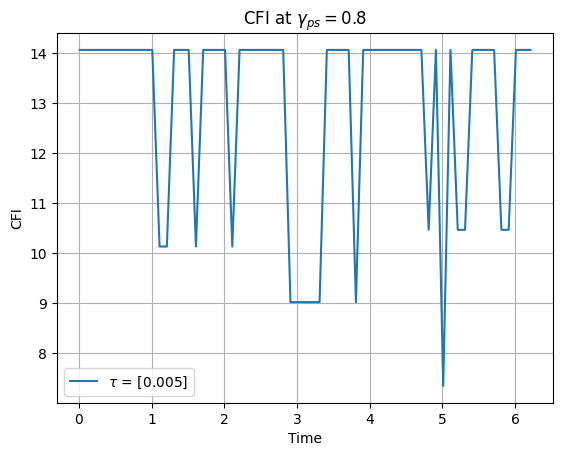

In [54]:
plt.plot(Data[:,0], Data[:,1], label = f'$\\tau$ = {tau_set}')
plt.title(f'CFI at $\gamma_{{ps}} = {gamma_ps_set}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()
plt.show()

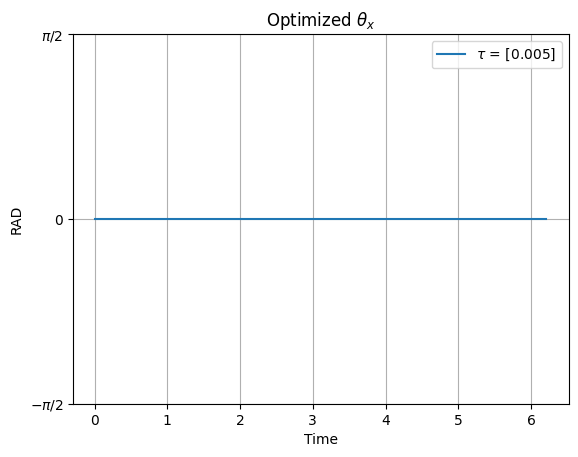

In [55]:
plt.plot(Data[:,0], Data[:,2], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

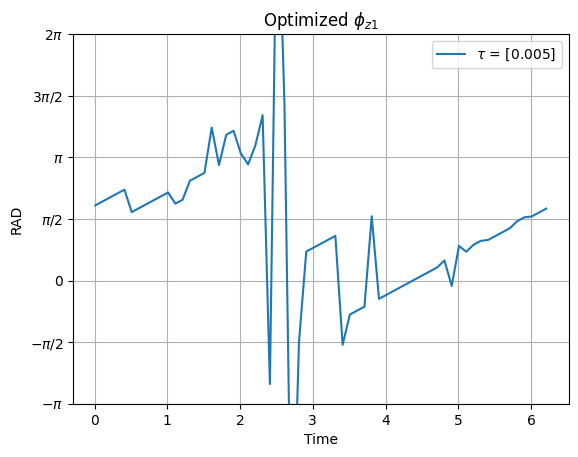

In [56]:
plt.plot(Data[:,0], Data[:,3], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z1}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [57]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z1:", f"{Data[idx, 3]:.8f}")

PHI: 0.01 phi_z1: 1.91703344
PHI: 0.11 phi_z1: 2.01703344
PHI: 0.21 phi_z1: 2.11703346
PHI: 0.31 phi_z1: 2.21703346
PHI: 0.41 phi_z1: 2.31703346
PHI: 0.51 phi_z1: 1.74455919
PHI: 0.61 phi_z1: 1.84455919
PHI: 0.71 phi_z1: 1.94455920
PHI: 0.81 phi_z1: 2.04455919
PHI: 0.91 phi_z1: 2.14455919
PHI: 1.01 phi_z1: 2.24455919
PHI: 1.11 phi_z1: 1.96086266
PHI: 1.21 phi_z1: 2.06086267
PHI: 1.31 phi_z1: 2.54455919
PHI: 1.41 phi_z1: 2.64455919
PHI: 1.51 phi_z1: 2.74455919
PHI: 1.61 phi_z1: 3.90072999
PHI: 1.71 phi_z1: 2.94455919
PHI: 1.81 phi_z1: 3.71703352
PHI: 1.91 phi_z1: 3.81703346
PHI: 2.01 phi_z1: 3.24455919
PHI: 2.11 phi_z1: 2.96086267
PHI: 2.21 phi_z1: 3.44455919
PHI: 2.31 phi_z1: 4.21703345
PHI: 2.41 phi_z1: -2.63862612
PHI: 2.51 phi_z1: 10.70021878
PHI: 2.61 phi_z1: 4.51703346
PHI: 2.71 phi_z1: -7.94933715
PHI: 2.81 phi_z1: -1.56615184
PHI: 2.91 phi_z1: 0.73816432
PHI: 3.01 phi_z1: 0.83816431
PHI: 3.11 phi_z1: 0.93816432
PHI: 3.21 phi_z1: 1.03816432
PHI: 3.31 phi_z1: 1.13816429
PHI: 3.41 

In [58]:
get_constraints(1.51)

[(-0.001, 0.001),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (0.89271456, 0.89271456),
 (1.5707963267948966, 1.5707963267948966)]

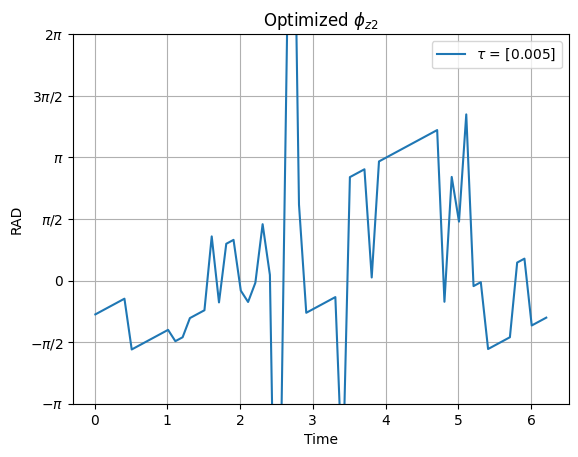

In [59]:
plt.plot(Data[:,0], Data[:,4], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z2}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [60]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z2:", f"{Data[idx, 4]:.8f}")

PHI: 0.01 phi_z2: -0.86342695
PHI: 0.11 phi_z2: -0.76342691
PHI: 0.21 phi_z2: -0.66342698
PHI: 0.31 phi_z2: -0.56342699
PHI: 0.41 phi_z2: -0.46342699
PHI: 0.51 phi_z2: -1.75816567
PHI: 0.61 phi_z2: -1.65816567
PHI: 0.71 phi_z2: -1.55816568
PHI: 0.81 phi_z2: -1.45816567
PHI: 0.91 phi_z2: -1.35816567
PHI: 1.01 phi_z2: -1.25816567
PHI: 1.11 phi_z2: -1.54690934
PHI: 1.21 phi_z2: -1.44690935
PHI: 1.31 phi_z2: -0.95816567
PHI: 1.41 phi_z2: -0.85816567
PHI: 1.51 phi_z2: -0.75816567
PHI: 1.61 phi_z2: 1.12531669
PHI: 1.71 phi_z2: -0.55816567
PHI: 1.81 phi_z2: 0.93657282
PHI: 1.91 phi_z2: 1.03657302
PHI: 2.01 phi_z2: -0.25816567
PHI: 2.11 phi_z2: -0.54690935
PHI: 2.21 phi_z2: -0.05816568
PHI: 2.31 phi_z2: 1.43657306
PHI: 2.41 phi_z2: 0.14183433
PHI: 2.51 phi_z2: -10.92979763
PHI: 2.61 phi_z2: 1.73657302
PHI: 2.71 phi_z2: 14.40294363
PHI: 2.81 phi_z2: 1.93657301
PHI: 2.91 phi_z2: -0.82258894
PHI: 3.01 phi_z2: -0.72258893
PHI: 3.11 phi_z2: -0.62258893
PHI: 3.21 phi_z2: -0.52258893
PHI: 3.31 phi_z2

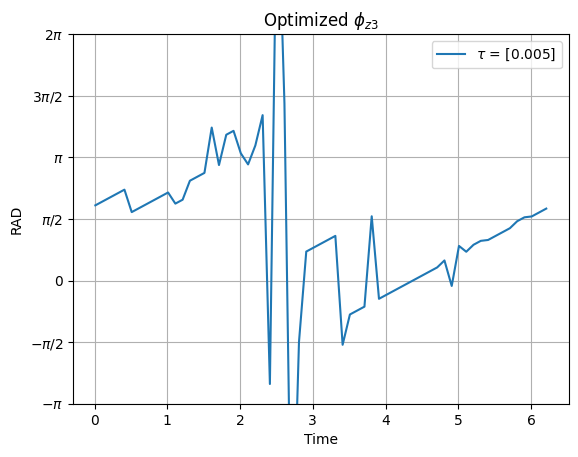

In [61]:
plt.plot(Data[:,0], Data[:,5], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z3}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [62]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z3:", f"{Data[idx, 5]:.8f}")

PHI: 0.01 phi_z3: 1.91703344
PHI: 0.11 phi_z3: 2.01703344
PHI: 0.21 phi_z3: 2.11703346
PHI: 0.31 phi_z3: 2.21703346
PHI: 0.41 phi_z3: 2.31703346
PHI: 0.51 phi_z3: 1.74455919
PHI: 0.61 phi_z3: 1.84455919
PHI: 0.71 phi_z3: 1.94455920
PHI: 0.81 phi_z3: 2.04455919
PHI: 0.91 phi_z3: 2.14455919
PHI: 1.01 phi_z3: 2.24455919
PHI: 1.11 phi_z3: 1.96086266
PHI: 1.21 phi_z3: 2.06086267
PHI: 1.31 phi_z3: 2.54455919
PHI: 1.41 phi_z3: 2.64455919
PHI: 1.51 phi_z3: 2.74455919
PHI: 1.61 phi_z3: 3.90072999
PHI: 1.71 phi_z3: 2.94455919
PHI: 1.81 phi_z3: 3.71703352
PHI: 1.91 phi_z3: 3.81703346
PHI: 2.01 phi_z3: 3.24455919
PHI: 2.11 phi_z3: 2.96086267
PHI: 2.21 phi_z3: 3.44455919
PHI: 2.31 phi_z3: 4.21703345
PHI: 2.41 phi_z3: -2.63862612
PHI: 2.51 phi_z3: 10.70021878
PHI: 2.61 phi_z3: 4.51703346
PHI: 2.71 phi_z3: -7.94933715
PHI: 2.81 phi_z3: -1.56615184
PHI: 2.91 phi_z3: 0.73816432
PHI: 3.01 phi_z3: 0.83816431
PHI: 3.11 phi_z3: 0.93816432
PHI: 3.21 phi_z3: 1.03816432
PHI: 3.31 phi_z3: 1.13816429
PHI: 3.41 

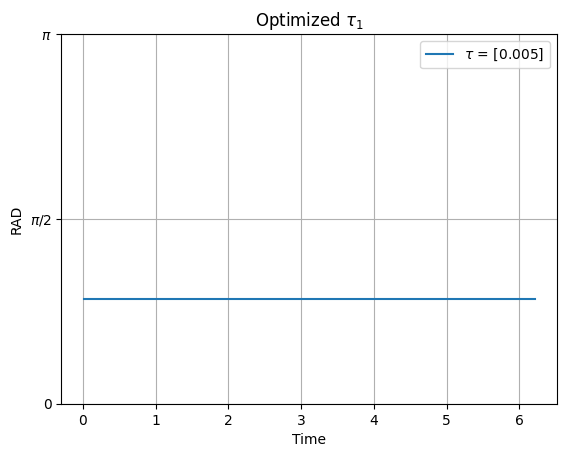

In [63]:
plt.plot(Data[:,0], Data[:,6], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\tau_{1}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [64]:
Data[:,6]

array([0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721, 0.88992721, 0.88992721,
       0.88992721, 0.88992721, 0.88992721])

In [65]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "tau_1:", f"{Data[idx, 6]:.8f}")

PHI: 0.01 tau_1: 0.88992721
PHI: 0.11 tau_1: 0.88992721
PHI: 0.21 tau_1: 0.88992721
PHI: 0.31 tau_1: 0.88992721
PHI: 0.41 tau_1: 0.88992721
PHI: 0.51 tau_1: 0.88992721
PHI: 0.61 tau_1: 0.88992721
PHI: 0.71 tau_1: 0.88992721
PHI: 0.81 tau_1: 0.88992721
PHI: 0.91 tau_1: 0.88992721
PHI: 1.01 tau_1: 0.88992721
PHI: 1.11 tau_1: 0.88992721
PHI: 1.21 tau_1: 0.88992721
PHI: 1.31 tau_1: 0.88992721
PHI: 1.41 tau_1: 0.88992721
PHI: 1.51 tau_1: 0.88992721
PHI: 1.61 tau_1: 0.88992721
PHI: 1.71 tau_1: 0.88992721
PHI: 1.81 tau_1: 0.88992721
PHI: 1.91 tau_1: 0.88992721
PHI: 2.01 tau_1: 0.88992721
PHI: 2.11 tau_1: 0.88992721
PHI: 2.21 tau_1: 0.88992721
PHI: 2.31 tau_1: 0.88992721
PHI: 2.41 tau_1: 0.88992721
PHI: 2.51 tau_1: 0.88992721
PHI: 2.61 tau_1: 0.88992721
PHI: 2.71 tau_1: 0.88992721
PHI: 2.81 tau_1: 0.88992721
PHI: 2.91 tau_1: 0.88992721
PHI: 3.01 tau_1: 0.88992721
PHI: 3.11 tau_1: 0.88992721
PHI: 3.21 tau_1: 0.88992721
PHI: 3.31 tau_1: 0.88992721
PHI: 3.41 tau_1: 0.88992721
PHI: 3.51 tau_1: 0.8

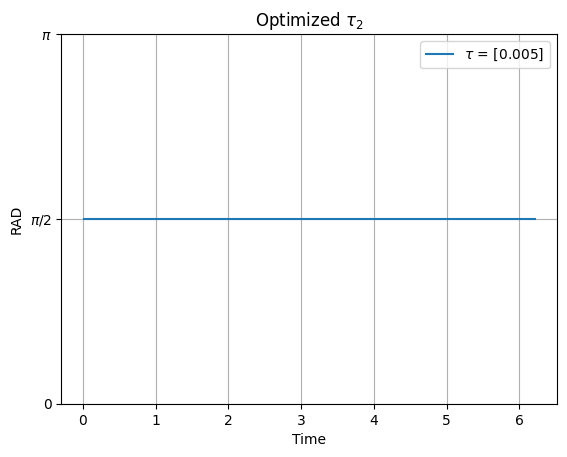

In [66]:
plt.plot(Data[:,0], Data[:,7], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\tau_{2}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()